# ECON622: Computational Economics with Data Science Applications

Embeddings, NLP, and LLMs

Jesse Perla (University of British Columbia)

# Overview

## Summary

-   Relate embeddings to autoencoders and representation learning
-   Discuss text and other embeddings
-   Better discuss “out of distribution”, transfer learning, and fine
    tuning
-   Introduce self-supervised learning and semi-supervised learning
-   Use the OpenAI and Hugging Face Packages
-   Prepare to discuss attention and the transformer architecture and
    foundation models in the next lecture

## References

-   These notes are a bare-bones introduction. See references for more
-   See Mellisa Dell’s Survey [Deep Learning for
    Economists](https://arxiv.org/abs/2407.15339) and
    [Course](https://econdl.github.io/)
    -   [Topic and Sentiment
        Classification](https://econdl.github.io/intro/2023/03/22/lecture14.html)
    -   [Semantic and Syntactic
        Similarity](https://econdl.github.io/intro/2023/03/02/lecture11.html)
-   [ProbML Book 1](https://probml.github.io/pml-book/book1.html) and
    [ProbML Book 2](https://probml.github.io/pml-book/book2.html)

## Packages

Introducing new packages from OpenAI and Hugging Face

In [2]:
import openai
import transformers
import torch
from torch.nn.functional import cosine_similarity
from openai import OpenAI
from transformers import pipeline, AutoTokenizer, AutoModel # Hugging Face
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

## OpenAI

-   Sign up for the [OpenAI Platform](https://platform.openai.com/)
    -   Free for limited numbers of “tokens”
-   Go to the `API keys` tab and create a key
-   In your terminal, set `OPENAI_API_KEY` to this value (see
    [here](https://platform.openai.com/docs/quickstart?desktop-os=macOS#create-and-export-an-api-key))

# Is (Some) ML Just Fancy Logit?

## Discrete Random Variables

-   Up until now, we have mostly been interested in continuous outputs
    from our models
-   When working with NLP/etc. we usually have discrete outputs such as
    a classification or prediction of the next “token”
-   Lets review basic econometrics of logit and classification problems
    and explain how they work with learned representations

## Logit and Classification

-   Logit takes observables $X$, a binary outcome $Y$ from some
    population distribution and coefficients $\beta$ $$
    \mathbb{P}(Y = 1 | X) = \frac{\exp(X\cdot \beta)}{1 + \exp(X\cdot \beta)}
    $$
    -   In the background is a population distribution $\mu^*$ over
        $(Y,X)$
    -   The parameters $\beta$ are usually estimated with maximum
        likelihood with samples from $\mu^*$ (e.g., equivalent to ERM
        for regression)
    -   $X$ are handpicked observables, often transformed by economists
        (e.g., “feature engineering” in ML-jargon)

## Multinomial Logit

-   More generally, with $K$ possible outcomes, we have a multinomial
    logit model $$
    \mathbb{P}(Y = k | X) = \frac{\exp(X\cdot \beta_k)}{\sum_{j=1}^K \exp(X\cdot \beta_j)}
    $$
-   The $\beta$ (matrix) are usually estimated with maximum
    (log)-likelihood $$
    \min_{\beta}\left\{- \sum_{(X, y)\in\mathcal{D}} \log \mathbb{P}(Y = y | X;\beta)\right\}
    $$

## Nesting Representations

-   Often best to think of deep-learning as finding good representations
    of the data, $\phi : \mathcal{X} \to \mathcal{Z}$ and then a thin
    mapping or projection of that representation to an outcome space,
    $\hat{f} : \mathcal{Z} \to \mathcal{Y}$
-   With discrete-valued multinomial logit maps to distribution
    $\mathcal{Y}\in\mathbb{R}^K$ $$
    \mathbb{P}(Y = k | X;\beta,\theta) = \frac{\exp(\phi(X;\theta)\cdot \beta_k)}{\sum_{j=1}^K \exp(\phi(X;\theta)\cdot \beta_j)}
    $$
    -   Then MLE:
        $\min_{\beta, \theta} \left\{- \sum_{(X, y)\in\mathcal{D}} \log \mathbb{P}(Y = y | X;\beta, \theta)\right\}$
    -   As always, with ML we can just nest the $\phi$ and $\hat{f}$ in
        the same function to jointly optimize all parameters

## Turning “Features” to Probabilities

-   Common to have a complicated internal approximation which they want
    to convert to a discrete action/state/prediction/classification
-   The easiest approach, pervasive in ML methods, is to convert this to
    a probability distribution over discrete outcomes
    -   “softmax”, i.e. the multinomial logit PMF, provides an easy way
        to do this
-   Among other reasons, this makes the objective’s differentiable and
    allows for gradient-based optimization

## Is ML Just Fancy Logit?

-   At this point many economists will say that this all just sounds
    like fancy logit
    -   That is **mostly true**, for this type of problem
    -   **But that is not insult!** Multinomial logit is a powerful, and
        MLE is well understood. Logit/LLS/etc. are simple ML methods
-   The key difference with deep learning + logit is important:
    -   Economists typically work with engineered representations (e.g.,
        taking logs, first-differences, variable selection)
    -   But deep learning lets us use learned representations,
        $\phi(X;\theta)$

## Classic ML Approaches with LASSO

-   Worth contrasting to a “classic” ML. If the “features/observables”
    of $X$ are:
    -   Assumed to map to the output probabilities linearly
    -   Likely to overfit, or not be identified, by using irrelevant
        features
-   Then you can do things like a LASSO regularized multinomial logit $$
    \min_{\beta} \left\{- \sum_{(X, y)\in\mathcal{D}} \log \mathbb{P}(Y = y | X;\beta) + \lambda ||\beta||_1\right\}
    $$
    -   i.e., penalize the 1-norm of the coefficients, which encourages
        sparsity of $\beta$ for $\lambda > 0$. Deep Learning often
        achieves this regularization indirectly (as discussed in the
        Overparametrization lecture)

## Terminology Differences

-   Standard MLE loss in this setup is the “cross-entropy loss”
-   The formula for the multinomial logit is called the “softmax”
    function
-   When thinking about the separate mapping of the representation to
    the output, we often of it as the last layer
-   And remember that we can have representations in the latent space:
    -   If there are $N$ observables to predict $K$ outcomes, then in
        multinomial logit we estimate $N \times K$ parameters
    -   But with representations, $z = \phi(X;\theta)$, it might be a
        much higher (or lower) dimensional mapping to $K$ outcomes
-   **Confusion**: “Inference” in some ML-speak is simply evaluating
    $f(X)$

# Embeddings

## What is an Embedding?

In [3]:
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
          "role": "system",
          "content": "You provide 2 short bullet points, technical answers."
        },
        {
          "role": "user",
          "content": "What is an embedding?"
        }
    ]
)
print(completion.choices[0].message.content)

- An embedding is a numerical representation of data, typically in a continuous vector space, that captures semantic similarities and relationships between different pieces of information, such as words or images.
  
- In machine learning, embeddings are used to transform categorical variables into dense vectors, allowing algorithms to effectively process and understand high-dimensional and complex data.

## Latent Space

In [4]:
completion = client.chat.completions.create(model="gpt-4o-mini",
    messages=[
        {
          "role": "system",
          "content": "You provide 2 short bullet points, technical answers."
        },
        {
          "role": "user",
          "content": "What is an embedding?"
        },
        {
          "role": "assistant",
          "content": "- An embedding is a dense vector representation of objects, such as words, sentences, or images, that captures semantic meanings and relationships in a continuous vector space.\n- It transforms high-dimensional data into a lower-dimensional format while preserving essential properties, enabling easier computation in machine learning tasks."
        },
        {
          "role": "user","content": "What is the relationship to latent spaces?"
        },
    ]
)
print(completion.choices[0].message.content)

- Embeddings often occupy latent spaces, which are learned representations that capture underlying structures and features of the data, facilitating tasks like clustering or classification.
- The process of creating embeddings can be viewed as mapping the original high-dimensional data into a lower-dimensional latent space where similar items are closer together, enhancing interpretability and efficiency.

## Detour into OpenAI (others are similar)

-   This is making calls to the OpenAI API.
-   Three roles:
    -   **system**: setup for the LLM to establish the persona, how to
        respond, etc.
    -   **user**: the question or prompt
    -   **assistant**: the response
-   Note that in a sequence of calculates, we give the entire history
    including its own responses (tagged as `assistant`)
-   We will come back to this shortly. Think of this as information for
    conditioning.

## Embeddings Overview

-   Used loosely and inconsistently, but the spirit is the same
-   A mapping of some $x \in \mathcal{X}$ to a latent space
    $\phi(x) \in \mathcal{Z}$
-   Typically we want that $\mathcal{Z}$ as a continuous vector space of
    finite dimension
    -   Crucially, we can think of distances in that space (e.g.,
        $||\phi(x) - \phi(y)||$)
-   The dimension of $\mathcal{Z}$ may be smaller or larger than
    $\mathcal{X}$
    -   If larger, typically embeddings of data $x \in \mu^*$ are close
        to lower-dimensional manifold e.g., separating hyperplane in
        $\mathbf{R}^3$ with kernel
-   Sometimes, as with network embeddings, want to preserve norms
    -   e.g. if $||x - y||$ is small, then $||\phi(x) - \phi(y)||$ is
        small

## Inner Products Implicitly Define Norms (and Embeddings)

-   As we saw with kernels, the embedding may be implicit in an inner
    product
-   Kernels induce norms without explicitly forming the feature map,
    $\phi(x)$, to the embedding space—which would be defined implicitly
    by $K(x, x') = \phi(x)^T \phi(x')$.
-   As discussed, the benefit of kernel methods is that the embedding
    space may be infinite dimensional, but the kernel is finite
    dimensional. The cost is we cannot directly map $x$ to the embedding
    space

## Cosine Similarity

-   Canonical case of an inner product (with an associated norm, etc.)
-   Cosine similarity is the “angle” between two vectors in the
    embedding space $z = \phi(x)$ and $z' = \phi(x')$ $$
    \mathrm{sim}(z, z') = \frac{z \cdot z'}{||z|| ||z'||}
    $$
-   Interpretation: If $z$ and $z'$ are
    1.  close in the embedding space, then the cosine similarity is
        close to 1
    2.  orthogonal, then the cosine similarity is 0
    3.  opposite, then the cosine similarity is -1
-   Norm comparison $||z - z'||$ instead? Works but not invariant to
    scaling

## Learned vs. Engineered Embeddings

-   Embeddings are not related to a specific “supervised” goal, and
    there may be many useful embeddings for a given data set
-   We could engineer them (explicitly or implicitly).
    -   e.g., count frequency of words in text, define implicitly
        through a kernel
-   Or we can use learn them
    -   e.g., representation learning in a NN, PCA, etc.
-   Recall that when we fit a neural network, $f(x) = \hat{f}(\phi(x))$,
    we can think of $\phi(x)$ as an embedding of $x$ in a latent space
    mapped to output by a shallow $\hat{f}$

## Autoencoders and Compression

-   One sense of “optimality” of embeddings is whether you can find a
    representation which best compresses the data in a finite
    dimensional latent space (or a higher-dimensional latent space with
    a low-rank structure)
-   This underlies the idea of using an Autoencoder. See [ProbML Book
    1](https://probml.github.io/pml-book/book1.html) Section 20.3 and
    [ProbML Book 2](https://probml.github.io/pml-book/book2.html)
    Section 21
-   The idea is to find functions which “encode” the data into a latent
    space, and then “decode” it back to the original space

## Autoencoders and Dimensionality Reduction

-   General class of problems which they call auto-encoders in ML/data
    science
    -   Function $f$, the encoder, maps $X$ to a latent space $Z$, which
        may be lower-dimensional
    -   Function $g$, the decoder, maps points in the latent space $Z$
        back to $X$
    -   $\theta_e$ and $\theta_d$ are parameters for $f$ and $g$ which
        we are trying to find
-   Then the goal is to find the $\theta_e$ and $\theta_d$ parameters
    for our encoder, $f$, and decoder, $g$, where for as many $X$ as
    possible we have

$$
g(f(x; \theta_e); \theta_d) \approx x
$$

-   The $z = f(x;\theta_e)$ may or may not be lower-dimensional

## Optimization Problem for an Autoencoder

-   If we had a distribution for $x$ then can solve

    $$
    \min_{\theta_e, \theta_d} \mathbb{E}_{x\sim \mu^*}||g(f(x; \theta_e); \theta_d) - x||_2^2
    $$

-   Fit with ERM for $\mathcal{D} \sim \mu^*$

$$
\min_{\theta_e, \theta_d} \frac{1}{|\mathcal{D}|} \sum_{x \in \mathcal{D}} ||g(f(x; \theta_e); \theta_d) - x||_2^2
$$

## PCA as the Optimal Linear Autoencoder

-   Let $f(x) = W^T x$ and $g(z) = W z$ where
    $W \in \mathbb{R}^{M \times L}$. If $\hat{x} \approx W W^T x$,
    “reconstruction error” is $||\hat{x} - x||_2^2$.

$$
\min_{W} \frac{1}{N} \sum_{n=1}^N ||W \overbrace{W^T x_n}^{z_n = f(x_n;W)} - x_n||_2^2,\quad \text{with } W^T W = I
$$

# Word Embeddings

## Tokens and Vocabulary

-   Rather than trying to embed individual characters, it is usually
    better to encode entire words (and, later, sentences, paragraphs,
    text+images, etc.)
-   If we decide on something that separates them, e.g. whitespace, then
    we can map words to an integer index for each word
-   Lets use a prebuilt tokenizer from Hugging Face. With a different
    type of data (e.g., historical data) you may want to customize what
    a “word” is

In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
tokens = tokenizer.tokenize("hello, hugging face")
print(tokens)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(token_ids)

['hello', ',', 'hugging', 'face']
[7592, 1010, 17662, 2227]

## Token IDs to Embeddings

-   The discrete values for the different words are not inherently
    comparable
-   An embedding will put them in a space where we can consider
    similarity
-   For now, lets use embedding from a prebuilt “model”

In [6]:
model = AutoModel.from_pretrained("bert-base-uncased")
def get_embedding(sentence):
    tokens = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**tokens)
        embeddings = outputs.last_hidden_state
        # will see there are 3 total tokens, only middle is the sentence
        return outputs.last_hidden_state[0,1:-1,:].squeeze()
embed = get_embedding("hello")
print(embed.shape)

torch.Size([768])

## Similarity

-   Measure distances in embedding space with cosine similarity or norms
-   Because we are in higher-dimensions, there can be different reasons
    for similarity. e.g., bank for money vs. the bank of a river, but
    river and money are not as similar

In [7]:
embed_bank = get_embedding("bank")
embed_banks = get_embedding("banks")
embed_river = get_embedding("river")
embed_money = get_embedding("money")

print(f"sim(bank, banks) = {cosine_similarity(embed_bank, embed_banks, dim=0)}")
print(f"sim(bank, river) = {cosine_similarity(embed_bank, embed_river, dim=0)}")
print(f"sim(bank, money) = {cosine_similarity(embed_bank, embed_money, dim=0)}")
print(f"sim(river, money) = {cosine_similarity(embed_river, embed_money, dim=0)}")

sim(bank, banks) = 0.743811845779419
sim(bank, river) = 0.5635619163513184
sim(bank, money) = 0.6932224035263062
sim(river, money) = 0.5209330916404724

## Where Did the Embedding Come From?

-   As we will see below, `bert-base-uncased` is a model which can
    predict missing words as its “supervised” goal,
    $f(x) = \hat{f}(\phi(x))$
-   This code just ripped off the $\hat{f}(\cdot)$ layers and use the
    latent space $\phi(x)$
-   It is important to get a sense of how the representations were
    learned - as they may not be appropriate for your task

## Using OpenAI API

In [8]:
def get_openai_embedding(sentence):
  response = client.embeddings.create(input = [sentence], model="text-embedding-3-large")
  return torch.tensor(response.data[0].embedding)

embed_bank = get_openai_embedding("bank")
embed_banks = get_openai_embedding("banks")
embed_river = get_openai_embedding("river")
embed_money = get_openai_embedding("money")
print(f"sim(bank, banks) = {cosine_similarity(embed_bank, embed_banks, dim=0)}")
print(f"sim(bank, river) = {cosine_similarity(embed_bank, embed_river, dim=0)}")
print(f"sim(bank, money) = {cosine_similarity(embed_bank, embed_money, dim=0)}")
print(f"sim(river, money) = {cosine_similarity(embed_river, embed_money, dim=0)}")

sim(bank, banks) = 0.7782837152481079
sim(bank, river) = 0.4269741177558899
sim(bank, money) = 0.4394051432609558
sim(river, money) = 0.3747156262397766

# Bigger Embeddings

## Bag of Words

-   Words usually occur in sentences, paragraphs, etc.
-   Instead of embedding a single word, we can embed a block of text.
-   Simple starting point: compare the relative frequency of words
    1.  Turn the text into blocks of tokens with unique identifiers
    2.  Filter out tokens that are not useful (e.g., “the”, “a”, etc.)
    3.  Count the frequency of each token
    4.  The embedding is the vector of the frequency of each token
-   Many issues with this, but crucially it does not capture any sense
    of context dependent meaning of words, and is invariant to word
    order

## Sentence Embeddings with LLMs

-   Encode an entire sentence (i.e., a sequence of tokens) into a single
    embedding and compare for similarity
-   Since individual words are embedded, we just average for the
    sentence

In [9]:
e_1 = get_embedding("The man bites the dog").mean(dim=0)
e_2 = get_embedding("The dog chased the man").mean(dim=0)
e_3 = get_embedding("The man was chased by the dog").mean(dim=0)
print(f"sim(e_1, e_2) = {cosine_similarity(e_1, e_2, dim=0)}")
print(f"sim(e_1, e_3) = {cosine_similarity(e_1, e_3, dim=0)}")
print(f"sim(e_2, e_3) = {cosine_similarity(e_2, e_3, dim=0)}")

sim(e_1, e_2) = 0.8429715037345886
sim(e_1, e_3) = 0.8270692229270935
sim(e_2, e_3) = 0.9152544736862183

-   Note that the 2nd and 3rd are the most similar, and the 1st and 3rd
    the least.

## What About the OpenAI API?

In [10]:
e_1 = get_openai_embedding("The man bites the dog")
e_2 = get_openai_embedding("The dog chased the man")
e_3 = get_openai_embedding("The man was chased by the dog")
print(f"sim(e_1, e_2) = {cosine_similarity(e_1, e_2, dim=0)}")
print(f"sim(e_1, e_3) = {cosine_similarity(e_1, e_3, dim=0)}")
print(f"sim(e_2, e_3) = {cosine_similarity(e_2, e_3, dim=0)}")

sim(e_1, e_2) = 0.5414078831672668
sim(e_1, e_3) = 0.5226691961288452
sim(e_2, e_3) = 0.791109025478363

-   Same ordering. A good sign.

## Be Cautious, Interpretation is Tricky

In [11]:
e_1 = get_openai_embedding("The man bites the dog")
e_2 = get_openai_embedding("The dog chased the man")
e_3 = get_openai_embedding("The man was chased by the dog")
e_4 = get_openai_embedding("The man chased the dog")
print(f"sim(e_1, e_2) = {cosine_similarity(e_1, e_2, dim=0)}")
print(f"sim(e_1, e_3) = {cosine_similarity(e_1, e_3, dim=0)}")
print(f"sim(e_2, e_3) = {cosine_similarity(e_2, e_3, dim=0)}")
print(f"sim(e_3, e_4) = {cosine_similarity(e_3, e_4, dim=0)}")

sim(e_1, e_2) = 0.5413370728492737
sim(e_1, e_3) = 0.5225977897644043
sim(e_2, e_3) = 0.7911193370819092
sim(e_3, e_4) = 0.8597935438156128

-   Note that `sim(e_3, e_4) > sim(e_3, e_2)` even though they they seem
    to have the exact opposite meaning!
-   Why? There are many embeddings (e.g. bag of words) which make these
    close, and others where they are far apart. Hard to know without a
    sense of how it was trained.

## Clustering

-   Since embeddings provide a measure of similarity/distance, we can
    cluster it into groups or use other tools to find interpretations
-   There are various algorithms to cluster based on representations,
    and find the closest elements within the set of data for a new
    element
-   One approach: come up with a lower-dimensional embedding which
    preserves norms, as in [t-SNE (t-Distributed Stochastic Neighbor
    Embedding)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
    -   i.e., find a $h(\cdot)$ such that if $||x - y||$ is small, then
        \|\|$h(x) - h(y)||$ is small
    -   Generally better than k-means, etc. for this kind of problem,
        and allows you to project to 2 or 3 dimensional embeddings, not
        just discrete values

## Get Some Random Embeddings

In [12]:
vocab = tokenizer.get_vocab()
tokens = list(vocab.keys())
print(f"model has {len(tokens)} tokens")
special_tokens = ['##', '[MASK]', '[CLS]', '[SEP]', '[PAD]']
full_tokens = [token for token in tokens if not token.startswith('##') and token not in special_tokens]
print(f"model has {len(full_tokens)} full tokens (e.g. not special symbols, special tokens, etc.)")
sampled_tokens = np.random.choice(full_tokens, size=50, replace=False)
token_ids = [vocab[token] for token in sampled_tokens]
with torch.no_grad():
    embeddings = model.embeddings.word_embeddings(torch.tensor(token_ids))

model has 30522 tokens
model has 24690 full tokens (e.g. not special symbols, special tokens, etc.)

## Visualize with t-SNE

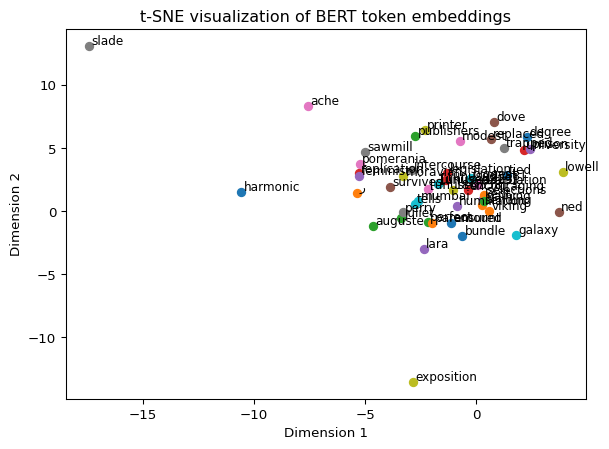

In [13]:
tsne = TSNE(n_components=2, random_state=0) # approx with 2 dim embedding
embeddings_2d = tsne.fit_transform(embeddings.numpy())
# Plot the t-SNE results
plt.figure()
for i, token in enumerate(sampled_tokens):
    x, y = embeddings_2d[i]
    plt.scatter(x, y)
    plt.text(x+0.1, y+0.1, token, fontsize=9)
plt.title('t-SNE visualization of BERT token embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

## Lowering the Embedding Dimension

-   As discussed, t-SNE is one way to project down to something
    visualizable
-   More generally, though, you can find a lower-rank approximation to
    the embedding space
-   With some APIs,
    (e.g. [OpenAI](https://platform.openai.com/docs/guides/embeddings/))
    they make this especially easy
    -   In particular, you can simply drop digits of precision on the
        embedding to make it coarser, following [this
        paper](https://arxiv.org/abs/2205.13147)
    -   See OpenAI docs for more details. Can [do this
        automatically](https://platform.openai.com/docs/api-reference/embeddings/create)
        by passing `dimensions`

## Classification

-   For classification tasks, we can use this embedding with
    representation learning and softmax (i.e., logit likelihood)
-   One strategy for classification
    1.  Embed sentences
    2.  Use some nonlinear transformations (e.g., NN) to get a
        representation of the embedding
    3.  Use a “softmax” to get a probability distribution over the
        classes
    4.  Fit with MLE as a “supervised” (multinormal logit) problem
-   Others use embeddings as inputs to different classification
    algorithms (e.g. [OpenAI random forest
    example](https://cookbook.openai.com/examples/classification_using_embeddings))

## Multi-Modal Embeddings

-   Embeddings can be used for more than just text
-   Images, audio, etc. can all be embedded
-   The key is to have a representation which is useful for the task at
    hand
-   For example, we can embed text and images together to predict the
    sentiment of a review

## Aligning Embeddings

-   Loosely, if you have related data on the same entities (e.g., labels
    on images) then you can work to align the embeddings of both
    -   e.g., a $\phi_1(X_{\text{image}})$ and $\phi_2(X_{\text{text}})$
        similar if the text describes the image
    -   Then you can attempt to get the $\phi_1$ and $\phi_2$ to be
        similar for that data
    -   If so, then you can map back and forth between image and text in
        the embedding space (i.e., take text, map to $\phi_2$ to the
        embedding space, then map back form the embedding to the image
        space)
-   See Melissa Dell’s [Multimodel
    Learning](https://econdl.github.io/intro/2023/02/28/lecture10.html).
    Complicated in practice (e.g., [contrastive
    learning](https://econdl.github.io/intro/2023/02/23/lecture8.html))
-   See [OpenAI’s multimodel example with
    CLIP](https://huggingface.co/learn/cookbook/en/faiss_with_hf_datasets_and_clip)
    for an example

# Sequential Data and Token Prediction

## Distribution of “Tokens”

-   In many cases, data has an inherent sequential ordering. e.g. time
    series, language, etc.
-   Consider conditional probabilities over $x_t \in \mathcal{X}$ which
    is discrete set of outcomes $k = 1, \ldots K$. Generically call
    these “tokens”
-   Objects of interest: for $x_1, x_2, \ldots, x_T$ for a sequence of
    length $T$, have a “population distribution” ,
    $\{x_1, \ldots, x_T\} \sim \mu^*$
-   We may want to condition on the past to predict the next token,
    condition on the entire sequence to predict missing ones, etc.

## Token Prediction from Conditional Probabilities

-   Given a sequence $x_1, x_2, \ldots, x_{t-1}$, model the conditional
    distribution: $$
    \mathbb{P}(x_t | x_{t-1}, x_{t-2}, \ldots, x_1)
    $$
    -   Where in the background these are done with marginal and
        conditional probabilities sampling the population distribution
        $\mu^*$
-   Basic strategy (details on “transformers” after we see how to use
    them):
    1.  Do an embedding for each token $\phi_1(x_t)$
    2.  Map those embeddings to some combined representation,
        $\phi_2(\phi_1(x_1), \ldots, \phi_1(x_{t-1}))$
    3.  Map that with “softmax” to get probabilities over
        $k = 1, \ldots, K$ for $x_t$
    4.  Fit with MLE as a “supervised” (multinormal logit) problem

## Provide Conditioning Tokens in the Prompt

-   See Melissa Dell’s
    [Prompting](https://www.dropbox.com/scl/fi/e8rnp61e9mv6es455f91c/lecture_prompting.pdf?rlkey=8mj1y59l3tjod34tp5vgk8akv&e=1&dl=0)
    lecture, Hugging Face’s
    [docs](https://huggingface.co/docs/transformers/en/tasks/prompting)
    and [Prompts for
    Economists](https://sites.google.com/view/lastunen/ai-for-economists?authuser=0)

In [14]:
client = OpenAI()
completion = client.chat.completions.create(
    model="gpt-4o-mini",
    temperature=0.7, # higher temperature adds "entropy"
    messages=[
        {
          "role": "system",
          "content": "You provide 2 short bullet points, technical answers."
        },
        {
          "role": "user",
          "content": "What is an embedding?"
        }
    ]
)
print(completion.choices[0].message.content)

- An embedding is a mathematical representation of discrete objects (like words, sentences, or images) in a continuous vector space, enabling machine learning models to capture semantic relationships and similarities.
- Common techniques for generating embeddings include Word2Vec, GloVe, and deep learning models such as BERT, which leverage neural networks to create high-dimensional representations.

## Concatenating Results

In [15]:
completion = client.chat.completions.create(model="gpt-4o-mini",
    messages=[
        {
          "role": "system",
          "content": "You provide 2 short bullet points, technical answers."
        },
        {
          "role": "user",
          "content": "What is an embedding?"
        },
        {
          "role": "assistant",
          "content": "- An embedding is a dense vector representation of objects, such as words, sentences, or images, that captures semantic meanings and relationships in a continuous vector space.\n- It transforms high-dimensional data into a lower-dimensional format while preserving essential properties, enabling easier computation in machine learning tasks."
        },
        {
          "role": "user","content": "What is the relationship to latent spaces?"
        },
    ]
)
print(completion.choices[0].message.content)

- Embeddings can be considered as specific types of representations within a latent space, where the latent space itself is an abstract, lower-dimensional space that captures essential features of high-dimensional data.
- The process of creating embeddings involves mapping input data into the latent space, allowing for efficient similarity comparisons and transformations while retaining meaningful relationships.

## Mental Model of Sequential Generation

1.  Start with a set of tokens, $x_1, x_2, \ldots, x_{t-1}$ (include
    **EVERYTHING**)
2.  Condition on those tokens to find the
    $\mathbb{P}(x_t | x_{t-1}, x_{t-2}, \ldots, x_1)$ distribution
3.  Sample from that to get the $x_t$ token
    -   “Temperature” settings increases/decreases the entropy of
        $\mathbb{P}(x_t | \cdot)$ artificially to encourage/discourage
        randomness
4.  Add its own generated token to the set of tokens,
    $x_1, x_2, \ldots, x_{t-1}, x_t$
5.  Condition on those tokens to find the
    $\mathbb{P}(x_{t+1} | x_t, x_{t-1}, \ldots, x_1)$ distribution
6.  Repeat until it hits a special “done” token (itself predicted) or
    reaches a maximum length

## Cardinality of the Estimated Conditional Distribution

-   ChatGPT and others generate text token-by-token auto-regressively
-   No Markov assumptions. $K^T$ possible sequences of $K$ tokens of
    length $T$
-   GPT3-ish sized LLMs support roughly $T=4,000$ with $K=50,000$ tokens
    -   Estimating a
        $\mathbb{P} : 50,000 \times 50,000^{4,000}\to [0,1]$ conditional
        PMF
    -   And growing. GPT4o supports $128k$ tokens for context (i.e.,
        conditioning) and $16k$ for “output”

## How Can This Possibly Work?

-   It sometimes feels like it has compressed and memorized the entire
    internet
-   We don’t always know the parameterization or number of tokens in the
    training data (remember, this largely uses MLE to train) but
    OpenAI’s GPT-3 was disclosed
    -   The $\mathbb{P}(\cdot | \cdot)$ is approximated by approximating
        175 billion parameters
    -   Trained on 300 billion tokens from close to a terrabyte of
        cleaned text
-   Which is **absurdly small amount of data** given the cardinality of
    $\mathbb{P}$
    -   Paraphrasing Mikhail Belkin: this is like estimating the library
        of congress with a molecule of ink.
    -   If the curse-of-dimensionality was the constraint, data would
        need to grow exponentially as $T$ increases. It doesn’t.

# Training

## Manifold Hypothesis + Engineering Heroics?

-   Plenty of interpretations for how this is possible, but a few key
    ones:
    1.  The Manifold Hypothesis, as we discussed in the Deep Learning
        lecture.
        -   Given the right “representation”, human knowledge is far
            simpler than it appears. Knowledge is easily compressible
            since it has an inherent order independent of language
    2.  Implicit and explicit regularization of various forms avoids
        overfitting
    3.  The “Transformer”, a masterpiece of modern engineering we will
        discuss in our next lecture

## More than MLE

-   While the lion’s share of this training may have been just sequently
    predicting the next token for the data distribution, more is done in
    practice.
-   e.g., “AI Alignment” which tries to encourage these models to
    capture socially desirable properties
    -   Encourage $\mathbb{P}$ to be less racist or safer than the
        underlying training data by penalizing certain outcomes
    -   Add rewards based on human labeled data
    -   Distorting the $\mu^*$ that you don’t want it to train with to
        ensure safety
-   Reinforcement Learning from Human Feedback (RLHF). e.g. data from
    flagging an answer (good vs. bad) to help encourage good solutions
-   And much more. An enormous undertaking for a big LLM.

## Good Representations Are Reusable!

-   As always, good representations tend to be useful for many tasks
-   This goes both ways. Can use
    -   Different tasks an be used to refine the representations used
        for sequential prediction, even if not our primary goal
    -   Representations trained for LLMs for tasks which have nothing to
        do with their original training
-   Crudely, can train a $f(x) = \hat{f}(\phi(x))$ and swap out the
    $\hat{f}$, or distort the $\hat{f}$ to provide artificial incentives
    to encourage good $\phi(\cdot)$
-   Whenever possible, start fitting a deep learning approximation from
    a previously trained one <!-- 
    ## Good Representations are Transferable
    - Remember: with most ML methods, the unsupervised part (e.g., learning the $\phi(\cdot)$ is most of the work)
    - We have good generalization performance when the representations are especially strong
    - Keep in mind that ML is being fit (e.g., with MLE) with a population distribution $\mu^*$ fixed.
      - If we are using a different distribution, we need to be careful!  Even for the same tasks
      - One option: refine our problem by helping it specialize
      - Another: provide more information (e.g. tokens) to condition on  -->

## Using “Unlabelled” Data

-   In many cases, we have a lot of data, but only a small amount of
    labeled data (i.e., with outcomes)
-   For example, there are many images, but we only have a few with
    human-coded descriptions
-   Or we have a large number of examples of text for monetary policy
    statements, but only a few with human-coded sentiment or outcomes
-   Given that most of the work in deep learning is finding the
    $\phi(\cdot)$, how can we use the data itself to improve the
    representations - which will hopefully improve the model for many
    downstream tasks?

## Semi-Supervised Learning

-   **Semi-supervised learning** combines a small amount of labeled data
    with a larger set of unlabeled data to improve model performance by
    leveraging the structure in the unlabeled data.
-   e.g., “Augment” data by adding noise, rotating images, for the
    labeled data we do have. This will add regularization, encourage
    important sources of representations (e.g., invariance to
    permutations)

## Self-Supervised learning

-   **Self-supervised learning** is a form of unsupervised learning
    where the model generates pseudo-labels or tasks from unlabeled data
    itself to learn useful representations without relying on external
    labels.
-   e.g., mask out some words and predict them, mask out time-series
    data to predict the missing values, etc.
-   See more in [general
    surveys](https://ieeexplore.ieee.org/abstract/document/10559458) and
    ones on [contrastive
    vs. generative](https://ieeexplore.ieee.org/abstract/document/9462394)

## Contrastive Learning

-   **Contrastive learning** is a form of self-supervised learning where
    the model is encouraged to keep the representations of similar data
    close, and dissimilar data further away.
-   For example, with a batch of sentences, predict the next token for
    the sentence, but also try to predict the next token of the OTHER
    sentences in the loss (which should be unrelated/constrastive)
    -   This encourages the model to learn the importance of context.
        See [SimCSE](https://arxiv.org/abs/2104.08821)

# Classification and Masking

## Hugging Face

-   Hugging Face provides a simple interface to many prebuilt
    transformer models, datasets, etc.
-   We can use these for predicting the next token, but also tasks like
    sentiment analysis, filling in missing tokens, etc.
-   Unlike the OpenAI API, we can download the models and use them
    locally, “fine-tune” them, etc.
-   See [Quick Tour](https://huggingface.co/docs/transformers/quicktour)
    for more

## Pipelines

-   The `pipeline` function in Hugging Face is a simple way to use
    prebuilt models for common tasks. See the [pipeline
    tutorial](https://huggingface.co/docs/transformers/main/en/pipeline_tutorial)
-   Loads pretrained models from public repositories

In [16]:
classifier = pipeline("sentiment-analysis") # defaults to a model
fill_masker = pipeline(model="google-bert/bert-base-uncased") # device=0) # to use GPU   

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'l

## Sentiment Analysis (defaults to “Positive” or “Negative”)

-   Defaulted to
    `distilbert/distilbert-base-uncased-finetuned-sst-2-english`

In [17]:
print(classifier("Transformers library is great."))
print(classifier("Transformers library is awful."))
print(classifier("I am ok with the transformers."))
print(classifier("Transformers are a toy from the 80s."))
print(classifier("The chicken crossed the road."))

[{'label': 'POSITIVE', 'score': 0.9998424053192139}]
[{'label': 'NEGATIVE', 'score': 0.9997472167015076}]
[{'label': 'POSITIVE', 'score': 0.9997096657752991}]
[{'label': 'POSITIVE', 'score': 0.9587399363517761}]
[{'label': 'NEGATIVE', 'score': 0.845471978187561}]

-   Not bad. But why is that `toy from the 80s` overwhelmingly positive,
    and `chicken crossed the road` moderately negative?

## Fill Masked

-   Finds
    $\mathbb{P}(x_t | x_T, x_{T-1}, \ldots x_{t+1}, x_{t-1}, x_{t-2}, \ldots, x_1)$
-   Some, like
    [BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased), were
    trained for this direct task
-   Often done with a special `[MASK]` token

In [18]:
fill_masker("This is a simple [MASK].",
            top_k=3) # 3 highest probability

[{'score': 0.04227157309651375,
  'token': 3291,
  'token_str': 'problem',
  'sequence': 'this is a simple problem.'},
 {'score': 0.03105001524090767,
  'token': 3160,
  'token_str': 'question',
  'sequence': 'this is a simple question.'},
 {'score': 0.029722511768341064,
  'token': 8522,
  'token_str': 'equation',
  'sequence': 'this is a simple equation.'}]

# Fine-Tuning

## Remember the Population Distribution!

-   The training was all done with a fixed population distribution
    $\mu^*$
-   If our population distribution is distributed differently, we need
    to be careful
-   Maybe we can condition on tokens appropriately, that we can align
    the conditional distribution (implicitly from $\mu^*$). Useful but
    success not guaranteed
-   Alternatively, we can specialize the model to our problem. Have
    specialized tokens, different emphasis in the text, etc.
    -   [Hugging Face provided pre-trained
        models](https://huggingface.co/?activityType=update-model&feedType=following)
        which are a good starting point for various domains, etc.
-   Even with the same $\mu^*$, perhaps the prebuilt representations are
    not ideal for our particular task. May need to tweak representations
    to improve the task

## No-Shot and Few-Shot Learning

-   When they talk about “no-shot” or “few-shot” learning in ML, they
    are thinking of using a prebuilt representation for a task almost as
    is (e.g., a new task $\hat{f}_2(\phi(x))$ given trained
    $\hat{f}_1(\phi(x))$) either with only minimal changes to
    $\hat{f}_2$ or none at all.
    -   Could remove the last layer and training with a few samples
-   Alternatively, since LLMs can handle rich conditioning information
    (including text descriptions and examples in the $x_1, \ldots x_T$)
    you might be able to give the examples for the “task” in the prompt
    itself and not actually train anything
-   This works often in practice, but requires tweaking to ensure the
    tokens for conditioning (i.e. the prompt) is appropriate

## Fine-Tuning

-   Other times, you want to take a pre-built model and do additional
    training to better align it with your population distribution or
    task.
-   If you just want to specialize the output, but leave the
    representations intact, then you may want to “freeze” the parameters
    for every layer except the last few (i.e., the $\hat{f}$
    parameters), or swap out the functional form entirely.
    -   You will see this referred to as
        [“freezing”](https://flax-linen.readthedocs.io/en/latest/guides/training_techniques/transfer_learning.html#optax-multi-transform)
        layers
    -   More generally, changing existing trained models is called
        [“model
        surgery”](https://flax.readthedocs.io/en/latest/guides/surgery.html)

## Hugging Face Example

-   See [hugging face
    docs](https://huggingface.co/docs/transformers/en/training) with
    [notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/pytorch/training.ipynb)
    -   Downloads a pre-built LLM
    -   Downloads Yelp Reviews data
    -   Swaps out the last classification layer
    -   Trained to predict the number of stars for the Yelp review  
-   [Open AI Fine
    tuning](https://platform.openai.com/docs/guides/fine-tuning/) is
    harder since it does not store the model locally
    -   On the other hand, because it runs on OpenAI servers it may be
        faster (albeit costs money)
    -   See other examples in the [Open AI
        Cookbook](https://cookbook.openai.com/)